In [677]:
import collections
import functools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import optimize
from scipy import special
from scipy import stats
from typing import Callable, NamedTuple, Tuple

In [47]:
LABELS = collections.OrderedDict([
    ('time', 'Time (weeks), $i$'),
    ('failures', 'Failures, $y_i$'),
    ('temperature', 'Temperature, $x_i$'),
])

failure_time_data = pd.DataFrame(collections.OrderedDict([
    ('time', ['${}$'.format(week) for week in range(1,13)] + ['$>12$']),
    ('failures', [210, 108, 58, 40, 17, 10, 7, 6, 5, 4, 2, 3, 15]),
    ('temperature', [24, 26, 24, 26, 25, 22, 23, 20, 21, 18, 17, 20, None]),
]))

with open('failure_time_data.tex', 'w') as f:
    f.write(
        pd.DataFrame(collections.OrderedDict(
            [(LABELS[i], value) for i, value in failure_time_data.items()])).to_latex(
            escape=False, index=False, na_rep=''))

failure_time_data

,time,failures,temperature
0,$1$,210,24.0
1,$2$,108,26.0
2,$3$,58,24.0
3,$4$,40,26.0
4,$5$,17,25.0
5,$6$,10,22.0
6,$7$,7,23.0
7,$8$,6,20.0
8,$9$,5,21.0
9,$10$,4,18.0


# Geometric Model

In [223]:
def score(y, p):
    y = np.asarray(y)
    N = len(y) - 1
    t = np.arange(1, len(y))
    return -N*y[-1]/(1-p) + np.sum(y[:-1]*(1/p - (t-1)/(1-p)))

def mle(y):
    y = np.asarray(y)
    return np.sum(y[:-1])/(y[-1]*(len(y) - 1) + np.sum(np.arange(1, len(y))*y[:-1]))

score(failure_time_data['failures'], mle(failure_time_data['failures']))
mle(failure_time_data['failures'])

0.35471698113207545

In [239]:
def fisher_information(y, p):
    N = len(y) - 1
    n = np.sum(y)
    return n*(1 - (1-p)**N)/(p*p*(1-p))

1/fisher_information(failure_time_data['failures'], mle(failure_time_data['failures']))

0.00016828364537217432

In [254]:
stats.norm.interval(
    0.95,
    loc=mle(failure_time_data['failures']),
    scale=np.sqrt(1/fisher_information(failure_time_data['failures'], mle(failure_time_data['failures']))))

(0.32929150780524236, 0.38014245445890854)

In [640]:
MU = 0.2
SIGMA = 0.08

def make_beta_shapes(mu, sigma):
    x = mu*(1-mu)/(sigma*sigma) - 1
    return mu*x, (1-mu)*x

PRIOR_ALPHA, PRIOR_BETA = make_beta_shapes(MU, SIGMA)
PRIOR_ALPHA, PRIOR_BETA

(4.800000000000001, 19.200000000000003)

In [647]:
def update_beta_shapes(prior_alpha, prior_beta, y):
    y = np.asarray(y)
    alpha = prior_alpha + np.sum(y[:-1])
    
    t = np.arange(1, len(y))
    N = len(y) - 1
    beta = prior_beta + np.sum((t-1)*y[:-1]) + y[-1]*N
    return alpha, beta 

ALPHA, BETA = update_beta_shapes(PRIOR_ALPHA, PRIOR_BETA, failure_time_data['failures'])
ALPHA, BETA 

(474.8, 874.2)

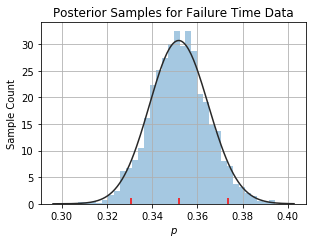

In [702]:
_PartialRvContinuous = NamedTuple(
    '_PartialRvContinuous', [
        ('pdf', Callable[[np.array], np.array]),
        ('fit', Callable[[np.array], Tuple[float, float]])])

np.random.seed(2018)
posterior_samples = stats.beta.rvs(a=ALPHA, b=BETA, size=2048)
#posterior_quantiles = np.quantile(posterior_samples, q=[0.05, 0.5, 0.95])
posterior_quantiles = stats.beta.ppf(q=[0.05, 0.5, 0.95], a=ALPHA, b=BETA)

fig = plt.figure(figsize=(4.5,3.5))
ax = fig.gca()
sns.distplot(posterior_samples, kde=False, ax=ax,
             fit=_PartialRvContinuous(pdf=stats.beta.pdf, fit=lambda _: (ALPHA, BETA)))
ax.vlines(posterior_quantiles, ymin=0, ymax=1, colors='r')
ax.grid(True)
ax.set_xlabel('$p$')
ax.set_ylabel('Sample Count')
ax.set_title('Posterior Samples for Failure Time Data')
fig.tight_layout()
fig.savefig('p1_posterior_samples.pdf', bbox_inches='tight')

In [703]:
posterior_quantiles

array([0.33070873, 0.35189124, 0.37346975])

In [637]:
np.sqrt(np.var(stats.beta.rvs(4.8, 19.2, size=10000)))

0.08023849939373665

## Beta Hyperparameter

In [621]:
def score(y, alpha_beta):
    alpha, beta = alpha_beta
    y = np.asarray(y)
    n = np.sum(y)
    N = len(y) - 1
    t = np.arange(1, N + 1)
    
    acc = -n*(special.digamma(alpha) - special.digamma(alpha + beta))
    acc += y[-1]*(np.array([
        special.digamma(alpha),
        special.digamma(beta + N),
    ]) - special.digamma(alpha + beta + N))
    acc += np.sum(y[:-1]*(np.array([
        [special.digamma(alpha + 1)]*N,
        special.digamma(beta + t - 1),
    ]) - special.digamma(alpha + beta + t)), -1)
    return acc
    
optimize.root(functools.partial(score, failure_time_data['failures']), [1, 1])

    fjac: array([[-0.35881411, -0.93340904],
       [ 0.93340904, -0.35881411]])
     fun: array([3.03845127e-09, 6.03972694e-09])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-2.30196430e-07,  1.98313292e-08])
       r: array([ 534.93252681, -635.33824205,  -36.60794047])
  status: 1
 success: True
       x: array([1.413336  , 1.38001102])

In [628]:
tmp = np.bincount(stats.geom.rvs(stats.beta.rvs(1.413336, 1.38001102, size=485)))
print(np.sum(tmp[13:]))
tmp[:13]

21


array([  0, 240,  89,  46,  23,  20,  15,  11,   7,   5,   3,   3,   2])

In [629]:
1.413336/(1.413336 + 1.38001102)

0.5059650626580582

    fjac: array([[-0.35881411, -0.93340904],
       [ 0.93340904, -0.35881411]])
     fun: array([3.03845127e-09, 6.03972694e-09])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-2.30196430e-07,  1.98313292e-08])
       r: array([ 534.93252681, -635.33824205,  -36.60794047])
  status: 1
 success: True
       x: array([1.413336  , 1.38001102])

In [361]:
1.413336/(1.413336 + 1.38001102)

0.5059650626580582

In [253]:
np.sqrt(0.00016828364537217432)*stats.norm.ppf(0.025) + 0.35471698113207545

0.32929150780524236

In [125]:
tmp = mle(failure_time_data['failures'])
tmp

np.sum((1 - tmp)**np.arange(13))

2.809667566181416

In [128]:
(1 - (1-tmp)**13)/tmp

2.8096675661814157

In [219]:
np.sum((np.arange(1,13) - 1)*((1-tmp)**(np.arange(1,13) - 1)))

4.9254021801953245

In [208]:
np.sum(np.arange(4)*tmp**np.arange(4))*(1-tmp)

0.4776779356290193

In [218]:
(tmp - tmp**4)/(1-tmp) - 3*tmp**4

0.4776779356290193

In [205]:
tmp/(1-tmp)**2

0.8518860504086725

In [221]:
(1 - tmp - (1-tmp)**12)/tmp**2 - 11*((1-tmp)**12)/tmp

4.925402180195324

In [188]:
tmp2 = 1-tmp
((tmp2 - tmp2**11)/tmp - tmp2**11)/tmp

5.041488246900949

In [255]:
#np.arange(1, len(failure_time_data))*
np.sum(np.arange(1, len(failure_time_data))*failure_time_data['failures'].values[:-1])

1145

In [292]:
alpha = 2
beta = 4

special.beta(alpha,beta)

0.05

In [296]:
s = np.arange(1000)
np.sum(special.beta(alpha + 1, beta + s))

0.04999900893936691

In [290]:
np.sum(special.gamma(beta + s)/special.gamma(alpha+beta+s+1))

0.024954212454212452

In [293]:
special.gamma(beta)/special.gamma(alpha+beta)/alpha

0.025

In [311]:
s = np.arange(10)
np.sum(special.beta(alpha + 1, beta + s))

0.04523809523809523

In [316]:
special.beta(alpha,beta) - special.beta(alpha, beta + 10)

0.045238095238095244

In [323]:
special.beta(alpha, beta + 3000)/special.beta(alpha,beta)

2.2155705869689195e-06

In [306]:
s = np.arange(100)
np.sum(alpha*special.gamma(alpha + beta)*special.gamma(beta+s)/special.gamma(beta)/special.gamma(alpha+beta+s + 1))

0.9981684981684983